# Stock Feature Pipeline

This notebook converts the raw data from the apis into model inputs


In [ ]:
# Import the required libraries and load in the environment variables
import hopsworks
import os
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Load the .env file
load_dotenv()

# Get the environment variables
hopsworks_api_key = os.getenv("HOPSWORKS_API_KEY")


### Getting Data From API


In [ ]:
def fetch_historical_data(ticker: str = "AMZN", period: str = "2y", interval: str = "1h") -> pd.DataFrame: 
    """
    Fetch historical stock data for a given ticker, period, and interval.

    Parameters:
    ticker (str): The stock ticker symbol (default is "AMZN").
    period (str): The period over which to fetch data (default is "2y").
    interval (str): The interval between data points (default is "1h").

    Returns:
    pd.DataFrame: A DataFrame containing the historical stock data with the following modifications:
        - Index reset to convert the date index into a column.
        - Time zone information removed from the 'Datetime' column.
        - Column names converted to lower case.
        - An 'id' column added as a primary key, which is a string representation of the 'datetime' column.
    """
    data = pd.DataFrame(yf.download(tickers=ticker, period=period, interval=interval, multi_level_index=False))

    # Reset the index to convert the date index into a column
    data = data.reset_index()

    # Remove the time zone information from the 'Datetime' column
    data['Datetime'] = pd.to_datetime(data['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S'))

    # Rename columns to lower case for consistency
    data.columns = [column.lower() for column in data.columns]

    # Add the 'id' column as a primary key, which is a string representation of the 'datetime' column
    data["id"] = [str(date) for date in data['datetime']]
    
    return data

In [ ]:
data = fetch_historical_data()
data.head()

[*********************100%***********************]  1 of 1 completed


,datetime,close,high,low,open,volume,id
0,2023-02-22 14:30:00,95.699997,97.010002,94.800003,95.099998,15243384,2023-02-22 14:30:00
1,2023-02-22 15:30:00,96.218399,96.980003,95.650002,95.690002,8365097,2023-02-22 15:30:00
2,2023-02-22 16:30:00,96.025597,96.550003,95.710098,96.220001,4727154,2023-02-22 16:30:00
3,2023-02-22 17:30:00,96.139999,96.300003,95.879997,96.029999,3013457,2023-02-22 17:30:00
4,2023-02-22 18:30:00,95.529999,96.308403,95.250000,96.155800,5525224,2023-02-22 18:30:00


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3494 entries, 0 to 3493
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  3494 non-null   datetime64[ns]
 1   close     3494 non-null   float64       
 2   high      3494 non-null   float64       
 3   low       3494 non-null   float64       
 4   open      3494 non-null   float64       
 5   volume    3494 non-null   int64         
 6   id        3494 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 191.2+ KB


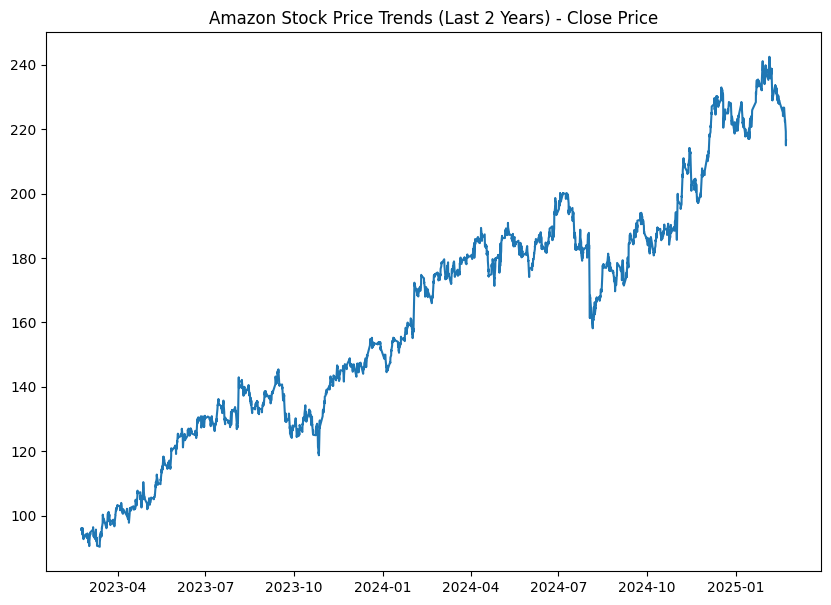

In [20]:

plt.figure(figsize=(10, 7))
plt.plot(data['datetime'], data['close'], label='Close Price')
plt.title("Amazon Stock Price Trends (Last 2 Years) - Close Price")
plt.show()

## Feature Engineering


In [31]:
from ta.momentum import RSIIndicator
from ta.trend import CCIIndicator

def calculate_indicators(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates RSI and CCI indicators for the given stock data.

    Args:
        data (pd.DataFrame): The stock data.

    Returns:
        pd.DataFrame: The stock data with RSI and CCI indicators.
    """
    rsi = RSIIndicator(data['close']).rsi()
    cci = CCIIndicator(data['high'], data['low'], data['close']).cci()
    data['rsi'] = rsi
    data['cci'] = cci

    return data.dropna()

In [32]:
# Calculate indicators
data = calculate_indicators(data)

data.head()

,datetime,close,high,low,open,volume,id,rsi,cci
19,2023-02-24 19:30:00,92.823997,93.235001,92.669899,92.970001,4999767,2023-02-24 19:30:00,32.315574,-105.323194
20,2023-02-24 20:30:00,93.489998,93.650002,92.529999,92.824997,8320491,2023-02-24 20:30:00,40.248223,-77.804206
21,2023-02-27 14:30:00,94.352097,94.779999,93.620003,94.279999,10798576,2023-02-27 14:30:00,48.639464,-15.820844
22,2023-02-27 15:30:00,93.680000,94.371002,93.230003,94.355003,7009890,2023-02-27 15:30:00,43.509454,-39.282996
23,2023-02-27 16:30:00,93.650002,93.779999,93.379997,93.681602,3575581,2023-02-27 16:30:00,43.289985,-43.533943


In [33]:
data.tail()

,datetime,close,high,low,open,volume,id,rsi,cci
3489,2025-02-21 16:30:00,217.630005,219.740005,217.399994,219.250000,4778204,2025-02-21 16:30:00,23.488227,-201.945381
3490,2025-02-21 17:30:00,216.049698,217.690598,215.949997,217.630005,7934021,2025-02-21 17:30:00,20.716787,-215.456538
3491,2025-02-21 18:30:00,214.960007,216.500000,214.740005,216.039993,6070526,2025-02-21 18:30:00,19.047821,-207.864825
3492,2025-02-21 19:30:00,216.439896,216.479904,214.750107,214.970001,5888288,2025-02-21 19:30:00,27.580595,-155.573258
3493,2025-02-21 20:30:00,216.490005,216.850006,215.630005,216.440002,5715615,2025-02-21 20:30:00,27.857881,-121.195865


## Data Ingestion to Feature Store


In [21]:
# Login to Hopsworks
project = hopsworks.login(api_key_value = str(hopsworks_api_key))

# Get the feature store
fs = project.get_feature_store()

2025-02-22 14:59:32,653 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-02-22 14:59:32,655 INFO: Initializing external client
2025-02-22 14:59:32,656 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-02-22 14:59:35,312 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1212597


In [34]:
# Create feature group
amazon_fg = fs.get_or_create_feature_group(
    name="amazon_stock_prices",
    description="Amazon last 5 year stock prices",
    version=1,
    online_enabled=True,
    primary_key=["id"],
    event_time="datetime"
)

# Insert into feature group
amazon_fg.insert(data)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1212597/fs/1200226/fg/1401447


Uploading Dataframe: 100.00% |██████████| Rows 3475/3475 | Elapsed Time: 00:03 | Remaining Time: 00:00


Launching job: amazon_stock_prices_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1212597/jobs/named/amazon_stock_prices_1_offline_fg_materialization/executions


(Job('amazon_stock_prices_1_offline_fg_materialization', 'SPARK'), None)

In [35]:
# Create a list of dictionaries with column names and descriptions
column_descriptions = [
    {'name': 'datetime', 'description': 'The date and time of the stock data'},
    {'name': 'close', 'description': 'The closing price of the stock'},
    {'name': 'high', 'description': 'The highest price of the stock during the period'},
    {'name': 'low', 'description': 'The lowest price of the stock during the period'},
    {'name': 'open', 'description': 'The opening price of the stock'},
    {'name': 'volume', 'description': 'The total number of shares or contacts traded during the period'},
    {'name': 'rsi', 'description': 'Relative Strength Index (RSI) for the stock'},
    {'name': 'cci', 'description': 'Commodity Channel Index (CCI) for the stock' },
    {'name': 'id', 'description': 'primary key'}
]

for desc in column_descriptions:
    amazon_fg.update_feature_description(desc['name'], desc['description'])